# Pseudo spectral method for synthetic data

## Imports

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import math as math
import time
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from gekko import GEKKO
from tqdm import tqdm

## Loading samples

In [4]:
samples = np.load(r'C:\Users\lebda\source\repos\reu\final\synthetic\parameter_estimation\synthetic_samples.npy')

In [5]:
samples

array([[ 1.25617896,  0.10254884,  0.64899385,  0.05500933, 19.00748518,
         9.91331287],
       [ 1.28225539,  0.10530746,  0.63484678,  0.05410552, 19.05594567,
         9.8174523 ],
       [ 1.28225539,  0.10530746,  0.63484678,  0.05410552, 19.05594567,
         9.8174523 ],
       ...,
       [ 1.29044851,  0.10931644,  0.60346002,  0.05079497, 19.70316669,
        10.55252757],
       [ 1.30439122,  0.11009406,  0.59798569,  0.04973568, 19.78419242,
        10.61332221],
       [ 1.34561442,  0.11519785,  0.58434048,  0.04819149, 20.42861732,
        10.47201536]], shape=(19001, 6))

In [6]:
parameters = np.mean(samples, axis=0)  # Use the mean of the samples for parameters

In [7]:
parameters

array([ 1.35389625,  0.11298256,  0.59335017,  0.04951507, 19.70033041,
       10.06022168])

## Necessary functions

In [8]:
def pred_prey(t, population, params): #the model
    prey, predator = population
    dpdt = params[0] * prey - params[1] * prey * predator
    drdt = -params[2] * predator + params[3] * prey * predator
    return [dpdt, drdt] 

def pred_prey_model(params, t_eval):
    z0 = [params[4], params[5]]  # initial conditions for prey and predator
    def ode(t, z):
        return pred_prey(t, z, params)  
    t_span = (t_eval[0], t_eval[-1])
    sol = solve_ivp(ode, t_span, z0, t_eval=t_eval, method='RK45')
    return sol

In [9]:
t_uncontrolled = np.linspace(0, 20, 60)

## Defining optimal control

In [10]:
def optimal_control(my_parameters, prey_initial, pred_initial, t_control_start=20, t_control_end=40, n_points_control=60):  # extended to 40 years with 60 points
    m = GEKKO(remote=False) 
    
    m.time = np.linspace(t_control_start, t_control_end, n_points_control)
    
    # extract parameters
    a, b, c, d = my_parameters[:4]
    
    # use parameter-specific initial conditions for control period
    # define variables for control period
    prey = m.Var(value =  prey_initial, lb=0)   
    predator = m.Var(value = pred_initial, lb=0)  
    
    control = m.MV(value = 0, lb = -100, ub=100) 
    control.STATUS = 1  
    
    # model equations with control
    m.Equation(prey.dt() == a * prey - b * prey * predator)
    m.Equation(predator.dt() == -c * predator + d * prey * predator - control)
    
    # steady state values for this parameter set
    steady_prey = c / d     
    steady_predator = a / b  
         
    # objective function with final state penalty
    m.Obj((prey - steady_prey)**2 + (predator - steady_predator)**2 + m.integral(control**2)) 

    m.options.IMODE = 6 
    m.options.SOLVER = 3
    
    return m, prey, predator, control

## Solving with GEKKO

In [11]:
def run_gekko(p_matrix):
    # initialize counters + trajectories list outside the loop
    failures = 0
    successes = 0
    trajectories = []
    error_messages = []  # track error messages

    time_start = time.time()

    # add progress bar for the parameter sets
    for i, parameters in enumerate(tqdm(p_matrix, desc="Processing parameter sets", unit="param")):
        params = parameters[:4]
        initial = parameters[4:6]

        try:
            # first, simulate the uncontrolled period for this parameter set to get initial conditions at t=20
            params_full = np.concatenate([params, initial])  # full parameter set including initial conditions
            uncontrolled_traj = pred_prey_model(params_full, t_uncontrolled)

            # get the populations at year 20 for this specific parameter set
            prey_20 = uncontrolled_traj.y[0][-1]  # prey population at year 20 for this parameter set
            pred_20 = uncontrolled_traj.y[1][-1]  # predator population at year 20 for this parameter set

            # use these parameter-specific initial conditions for optimal control
            model, prey, predator, control = optimal_control(params, prey_20, pred_20)

            # solve the optimization problem using the TRUE parameter model
            model.solve(disp=False)  # disp=False suppresses solver output

            # extract results from the TRUE parameter model
            t_controlled = model.time
            prey_controlled = prey.value
            predator_controlled = predator.value
            control_signal = control.value  # this is pesticide application rate

            if len(t_controlled) == 0 or len(prey_controlled) == 0 or len(predator_controlled) == 0:
                failures += 1
            else:
                # store the results in a dictionary
                trajectory = {
                    't': t_controlled,
                    'prey': prey_controlled,
                    'predator': predator_controlled,
                    'control_signal': control_signal,
                    'params': params,  # store parameters for reference
                    # store the uncontrolled trajectory for this parameter set
                    't_uncontrolled': uncontrolled_traj.t,
                    'prey_uncontrolled': uncontrolled_traj.y[0],
                    'predator_uncontrolled': uncontrolled_traj.y[1]
                }
                trajectories.append(trajectory)
                successes += 1

        except Exception as e:
            failures += 1
            error_msg = f"Parameter set {i}: {str(e)}"
            error_messages.append(error_msg)

    time_end = time.time()

    print(f"\n Final Results:")
    print(f"Success rate: {successes / (successes + failures) if (successes + failures) > 0 else 0:.2%}")
    print(f"Successful simulations: {successes}")
    print(f"Failed simulations: {failures}")
    print(f"Total trajectories generated: {len(trajectories)}")
    print()
    print("Total time:", time_end - time_start, "seconds")
    print("Time per simulation:", (time_end - time_start) / (successes + failures) if (successes + failures) > 0 else 0, "seconds")
    if failures > 0:
        print("\nError messages from failed simulations:")
        for msg in error_messages:
            print(msg)
    return trajectories

## Running the Function

In [12]:
trajectories = run_gekko(samples[::38])

Processing parameter sets:   0%|          | 0/501 [00:00<?, ?param/s]

Processing parameter sets: 100%|██████████| 501/501 [02:16<00:00,  3.68param/s]


 Final Results:
Success rate: 100.00%
Successful simulations: 501
Failed simulations: 0
Total trajectories generated: 501

Total time: 136.09359550476074 seconds
Time per simulation: 0.27164390320311527 seconds


In [13]:
np.save("real_pseudo_trajectories.npy", trajectories)

In [14]:
# sum up cost function for first 10 trajectories
costs = []
for trajectory in trajectories[:10]:
    # convert GEKKO vxalues to numpy arrays
    prey = np.array(trajectory['prey'])
    predator = np.array(trajectory['predator'])
    control_signal = np.array(trajectory['control_signal'])
    
    # calculate the cost function for this trajectory
    steady_prey = trajectory['params'][2] / trajectory['params'][3]
    steady_predator = trajectory['params'][0] / trajectory['params'][1]
    
    cost = np.sum((prey - steady_prey)**2 + (predator - steady_predator)**2 + control_signal**2)
    costs.append(cost)

# convert to numpy array and display results
costs = np.array(costs)
print("Individual costs for first 10 trajectories:")
print(costs)
print(f"\nTotal sum of all costs: {np.sum(costs):.2f}")
print(f"Average cost per trajectory: {np.mean(costs):.2f}")
print(f"Standard deviation of costs: {np.std(costs):.2f}")

Individual costs for first 10 trajectories:
[200.4273261  162.74795282 172.59670463 196.62191309 160.42601142
 198.45610221 167.84617528 166.34070799 146.34603951 173.5204891 ]

Total sum of all costs: 1745.33
Average cost per trajectory: 174.53
Standard deviation of costs: 17.26


C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\3501431385.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  prey = np.array(trajectory['prey'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\3501431385.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  predator = np.array(trajectory['predator'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\3501431385.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

In [15]:
# get common time grid (assume all trajectories have same time points)
if len(trajectories) == 0:
    print("No successful trajectories to analyze!")
    # Optionally, set default values or skip further analysis
    time_grid = np.array([])
    n_trajectories = 0
    n_time_points = 0
else:
    time_grid = trajectories[0]['t']  # Extract the time component from the first trajectory
    n_trajectories = len(trajectories)
    n_time_points = len(time_grid)

    # initialize arrays to store all trajectory data
    all_prey = np.zeros((n_trajectories, n_time_points))
    all_predator = np.zeros((n_trajectories, n_time_points))
    all_control = np.zeros((n_trajectories, n_time_points))

    # collect all trajectory data 
    # (idk how to do this in gekko, if it's possible, doesn't seem to run too long anyway)
    for i, trajectory in enumerate(trajectories):
        # convert GEKKO values to numpy arrays
        all_prey[i, :] = np.array(trajectory['prey'])
        all_predator[i, :] = np.array(trajectory['predator'])
        all_control[i, :] = np.array(trajectory['control_signal'])

    # calculate statistics
    prey_mean = np.mean(all_prey, axis=0)
    prey_std = np.std(all_prey, axis=0)
    predator_mean = np.mean(all_predator, axis=0)
    predator_std = np.std(all_predator, axis=0)
    control_mean = np.mean(all_control, axis=0)
    control_std = np.std(all_control, axis=0)

    # calculate 95% confidence intervals using percentiles (2.5% and 97.5%)
    prey_95_lower = np.percentile(all_prey, 2.5, axis=0)
    prey_95_upper = np.percentile(all_prey, 97.5, axis=0)
    predator_95_lower = np.percentile(all_predator, 2.5, axis=0)
    predator_95_upper = np.percentile(all_predator, 97.5, axis=0)
    control_95_lower = np.percentile(all_control, 2.5, axis=0)
    control_95_upper = np.percentile(all_control, 97.5, axis=0)

C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\1314796969.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_prey[i, :] = np.array(trajectory['prey'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\1314796969.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_predator[i, :] = np.array(trajectory['predator'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_41504\1314796969.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so pas

In [16]:
prey_data = np.load(r'C:\Users\lebda\source\repos\reu\final\synthetic\parameter_estimation\prey_noisy_1.npy')
predator_data = np.load(r'C:\Users\lebda\source\repos\reu\final\synthetic\parameter_estimation\predator_noisy_1.npy')

In [17]:
pred_prey_model (parameters, t_uncontrolled)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.390e-01 ...  1.966e+01  2.000e+01]
        y: [[ 1.970e+01  2.063e+01 ...  9.458e+00  1.102e+01]
            [ 1.006e+01  1.157e+01 ...  8.120e+00  7.882e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 134
     njev: 0
      nlu: 0

In [18]:
t_data = np.arange(21)  # integer years 0-20

# compute uncontrolled trajectories for all parameter sets to get uncertainty bands
n_samples = len(trajectories)

if n_samples == 0:
    print("No successful trajectories to analyze for uncontrolled period!")
    all_uncontrolled_prey = np.array([])
    all_uncontrolled_predator = np.array([])
    prey_uncontrolled_mean = np.array([])
    prey_uncontrolled_std = np.array([])
    predator_uncontrolled_mean = np.array([])
    predator_uncontrolled_std = np.array([])
    prey_uncontrolled_95_lower = np.array([])
    prey_uncontrolled_95_upper = np.array([])
    predator_uncontrolled_95_lower = np.array([])
    predator_uncontrolled_95_upper = np.array([])
else:
    # use the stored uncontrolled trajectories that match exactly with the controlled ones
    all_uncontrolled_prey = np.zeros((n_samples, len(t_uncontrolled)))
    all_uncontrolled_predator = np.zeros((n_samples, len(t_uncontrolled)))

    for i, trajectory in enumerate(trajectories):
        # use the stored uncontrolled trajectories that were computed with the same parameter set
        # interpolate to match our common time grid
        all_uncontrolled_prey[i, :] = np.interp(t_uncontrolled, trajectory['t_uncontrolled'], trajectory['prey_uncontrolled'])
        all_uncontrolled_predator[i, :] = np.interp(t_uncontrolled, trajectory['t_uncontrolled'], trajectory['predator_uncontrolled'])

    # calculate statistics for uncontrolled period
    prey_uncontrolled_mean = np.mean(all_uncontrolled_prey, axis=0)
    prey_uncontrolled_std = np.std(all_uncontrolled_prey, axis=0)
    predator_uncontrolled_mean = np.mean(all_uncontrolled_predator, axis=0)
    predator_uncontrolled_std = np.std(all_uncontrolled_predator, axis=0)

    # calculate 95% confidence intervals for uncontrolled period using percentiles
    prey_uncontrolled_95_lower = np.percentile(all_uncontrolled_prey, 2.5, axis=0)
    prey_uncontrolled_95_upper = np.percentile(all_uncontrolled_prey, 97.5, axis=0)
    predator_uncontrolled_95_lower = np.percentile(all_uncontrolled_predator, 2.5, axis=0)
    predator_uncontrolled_95_upper = np.percentile(all_uncontrolled_predator, 97.5, axis=0)

    # calculate prediction intervals (confidence intervals + measurement noise)
    # for uncontrolled period - use the consistent trajectories
    # prey_prediction_std_uncontrolled = np.sqrt(prey_uncontrolled_std**2 + prey_noise_std**2)
    # predator_prediction_std_uncontrolled = np.sqrt(predator_uncontrolled_std**2 + predator_noise_std**2)

    # for controlled period
    # prey_prediction_std_controlled = np.sqrt(prey_std**2 + prey_noise_std**2)
    # predator_prediction_std_controlled = np.sqrt(predator_std**2 + predator_noise_std**2)

## Plotting

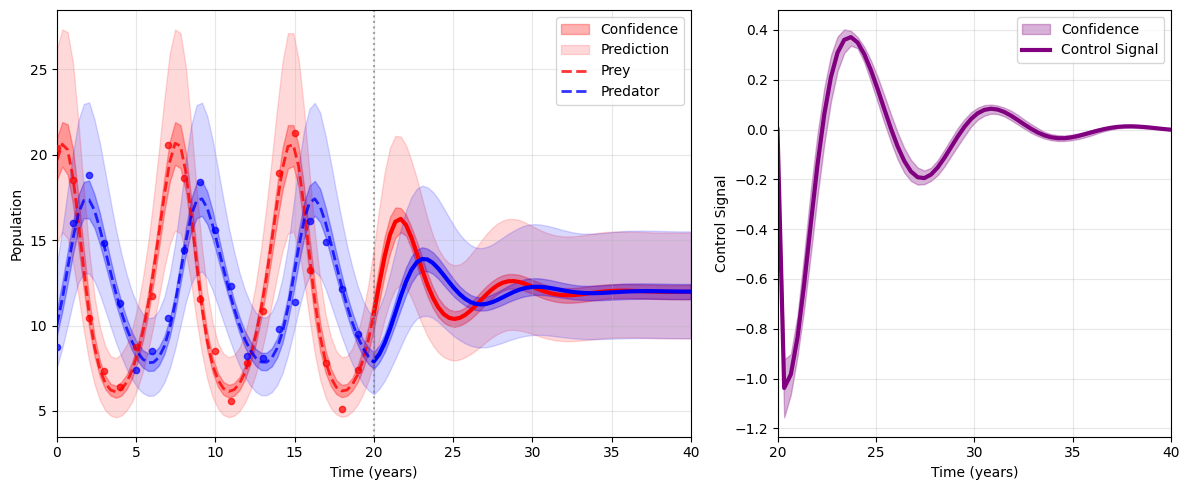

In [22]:
# ADJUSTABLE PARAMETER calculated from residual analysis
sigma = 0.2213

# Ensure time grids match at transition point
if t_uncontrolled[-1] != time_grid[0]:
    print(f"Warning: t_uncontrolled[-1] ({t_uncontrolled[-1]}) != time_grid[0] ({time_grid[0]}). Adjusting time_grid.")
    # If needed, insert time 20 at the start of time_grid
    if t_uncontrolled[-1] not in time_grid:
        time_grid = np.insert(time_grid, 0, t_uncontrolled[-1])
        # Also insert mean and bands for controlled period at start to match shape
        prey_mean = np.insert(prey_mean, 0, prey_uncontrolled_mean[-1])
        prey_std = np.insert(prey_std, 0, prey_uncontrolled_std[-1])
        predator_mean = np.insert(predator_mean, 0, predator_uncontrolled_mean[-1])
        predator_std = np.insert(predator_std, 0, predator_uncontrolled_std[-1])
        control_mean = np.insert(control_mean, 0, control_mean[0])
        control_std = np.insert(control_std, 0, control_std[0])
        prey_95_lower = np.insert(prey_95_lower, 0, prey_uncontrolled_95_lower[-1])
        prey_95_upper = np.insert(prey_95_upper, 0, prey_uncontrolled_95_upper[-1])
        predator_95_lower = np.insert(predator_95_lower, 0, predator_uncontrolled_95_lower[-1])
        predator_95_upper = np.insert(predator_95_upper, 0, predator_uncontrolled_95_upper[-1])
        control_95_lower = np.insert(control_95_lower, 0, control_95_lower[0])
        control_95_upper = np.insert(control_95_upper, 0, control_95_upper[0])

plt.figure(figsize=(12,5))

# CONFIDENCE + NOISE: POPULATION DYNAMICS (takes up ~60% of the width)
plt.subplot2grid((1, 5), (0, 0), colspan=3)

# CONFIDENCE INTERVALS (95% of trajectories) - Base layer
# PREY - Confidence bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
                 prey_uncontrolled_95_lower, 
                 prey_uncontrolled_95_upper, 
                 color='red', alpha=0.3, label='Confidence')

# PREDATOR - Confidence bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
                 predator_uncontrolled_95_lower, 
                 predator_uncontrolled_95_upper, 
                 color='blue', alpha=0.3)

# PREY - Confidence bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                 prey_95_lower, 
                 prey_95_upper, 
                 color='red', alpha=0.3)

# PREDATOR - Confidence bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                 predator_95_lower, 
                 predator_95_upper, 
                 color='blue', alpha=0.3)

# PREY - Prediction bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
            prey_uncontrolled_95_lower * math.exp(-sigma), 
            prey_uncontrolled_95_upper * math.exp(sigma),
                color='red', alpha=0.15, label=f'Prediction')

# PREDATOR - Prediction bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
            predator_uncontrolled_95_lower * math.exp(-sigma), 
            predator_uncontrolled_95_upper * math.exp(sigma), 
                color='blue', alpha=0.15)

# PREY - Prediction bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                prey_95_lower * math.exp(-sigma), 
                prey_95_upper * math.exp(sigma), 
                color='red', alpha=0.15)

# PREDATOR - Prediction bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                predator_95_lower * math.exp(-sigma), 
                predator_95_upper * math.exp(sigma), 
                color='blue', alpha=0.15)

# Mean trajectories on top
plt.plot(t_uncontrolled, prey_uncontrolled_mean, 'r--', linewidth=2, alpha=0.8, label='Prey')
plt.plot(t_uncontrolled, predator_uncontrolled_mean, color='blue', linestyle='--', linewidth=2, alpha=0.8, label='Predator')
plt.plot(time_grid, prey_mean, 'r-', linewidth=3)
plt.plot(time_grid, predator_mean, color='blue', linewidth=3)

# Add data points
min_len_prey = min(len(t_data), len(prey_data))
min_len_predator = min(len(t_data), len(predator_data))
plt.scatter(t_data[:min_len_prey], prey_data[:min_len_prey], color='red', s=20, alpha=0.7, zorder=5)
plt.scatter(t_data[:min_len_predator], predator_data[:min_len_predator], color='blue', s=20, alpha=0.7, zorder=5)

plt.axvline(x=20, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 40)

# Plot 2: Control Signal with trajectory confidence + fixed noise overlay (takes up ~40% of the width)
plt.subplot2grid((1, 5), (0, 3), colspan=2)

# CONFIDENCE INTERVALS (95% of control trajectories) - Base layer
plt.fill_between(time_grid, 
                 control_95_lower, 
                 control_95_upper, 
                 color='purple', alpha=0.3, label = 'Confidence')

# Control signal mean on top
plt.plot(time_grid, control_mean, 'purple', linewidth=3, label='Control Signal')

plt.xlabel('Time (years)')
plt.ylabel('Control Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(20, 40)
plt.xticks([20, 25, 30, 35, 40])  # Set x-axis ticks to show 4 sections (every 5 years)

plt.tight_layout()

# Save the figure in multiple vector formats
plt.savefig('pseudo_uncertainty.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()